In [6]:
import sys
import os
sys.path.insert(0, '/Users/james/Desktop/DRL_Hedging/')

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from financial_models.asset_price_models import GBM, StochasticVolatilityModel
from financial_models.option_price_models import BSM, BSMSABR
from hedging_env_gymnasium_a import HedgingEnv
from Utils import NormalizeObservationWrapper

from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback, BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy

seed = 345
np.random.seed(seed)
torch.manual_seed(seed)

In [7]:



mu = 0
D = 5
T = 10
num_steps = T*D
s_0 = 100
strike_price = s_0
sigma = 0.15
r = 0
trading_cost_para=0.003
L=100
v=0.6
rho=-0.4

apm = StochasticVolatilityModel(mu=mu, v=v, rho=rho, dt = 1/(252*D), s_0=s_0, sigma_0=sigma)
opm = BSMSABR(strike_price=strike_price, risk_free_interest_rate=r, T=T/252, dt=1/(252*D),v=v, rho=rho)
env = HedgingEnv(asset_price_model=apm, D=D, T=T, num_steps=num_steps, trading_cost_para=trading_cost_para,r=r,
                L=L, strike_price=strike_price, initial_holding_delta=False, mode="RA",
                option_price_model=opm)


env_id = "hedging_env_gymnasium"


/Users/james/Desktop/DRL_Hedging/financial_models/option_price_models.py:78: RuntimeWarning: invalid value encountered in double_scalars
  SABRIV = np.where(F == K, vol * B / (F ** (1 - beta)), A * B * Phi / Chi)


In [8]:
normalized_env = NormalizeObservationWrapper(env)
training_env = Monitor(normalized_env) 

In [9]:
# Callback for plotting
class PlottingCallback(BaseCallback):
    def __init__(self, check_freq: int, verbose=1):
        super(PlottingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.rewards = []
        self.steps = []

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            mean_reward, _ = evaluate_policy(self.model, self.training_env, n_eval_episodes=100)
            self.rewards.append(mean_reward)
            self.steps.append(self.n_calls)
        return True

    def _on_training_end(self) -> None:
        plt.plot(self.steps, self.rewards)
        plt.xlabel('Steps')
        plt.ylabel('Average Reward')
        plt.title('Training Progress')
        plt.show()



Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 50        |
|    ep_rew_mean     | -2.24e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 1154      |
|    time_elapsed    | 0         |
|    total_timesteps | 200       |
----------------------------------


/Users/james/Desktop/DRL_Hedging/financial_models/option_price_models.py:49: RuntimeWarning: divide by zero encountered in double_scalars
  d_1 = (np.log(asset_price / self.strike_price) + (self.risk_free_interest_rate + self.volatility**2 / 2)


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 50        |
|    ep_rew_mean     | -2.47e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 1244      |
|    time_elapsed    | 0         |
|    total_timesteps | 400       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 50        |
|    ep_rew_mean     | -2.58e+03 |
| time/              |           |
|    episodes        | 12        |
|    fps             | 1308      |
|    time_elapsed    | 0         |
|    total_timesteps | 600       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 50        |
|    ep_rew_mean     | -2.54e+03 |
| time/              |           |
|    episodes        | 16        |
|    fps             | 1039      |
|    time_elapsed    | 0         |
|    total_timesteps

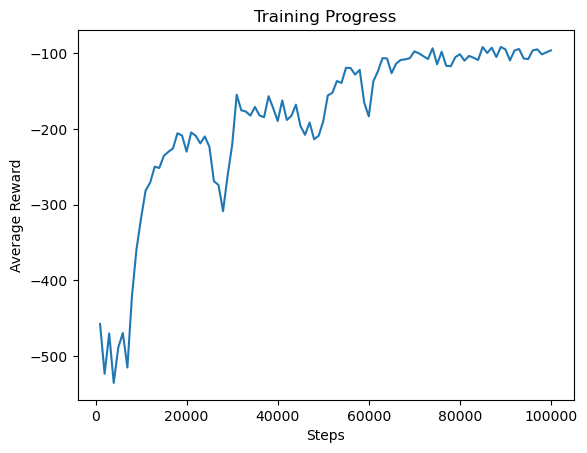

In [10]:
# Define the directory to save the models
save_path = "./trained_models"
if not os.path.exists(save_path):
    os.makedirs(save_path)

policy_kwargs = dict(activation_fn=nn.ReLU,
                     net_arch=dict(pi=[64,64,64], qf=[64,64,64]))

# Setup the model and training environment
model_sac = SAC("MlpPolicy", 
                training_env,
                verbose=1, 
                learning_rate=1e-4, 
                learning_starts=5000,
                buffer_size=16384, 
                batch_size=1024,
                gamma=1,
                policy_kwargs=policy_kwargs)


# Setup callbacks
checkpoint_callback_sac = CheckpointCallback(save_freq=10000, save_path=save_path, name_prefix="sac_model_sabr_3e-3")
plotting_callback = PlottingCallback(check_freq=1000)

# Train the models
total_timesteps = 1e5
model_sac.learn(total_timesteps=total_timesteps, callback=[checkpoint_callback_sac, plotting_callback])

# Save the trained models
model_sac.save(f"{save_path}/sac_final_sabr_3e-3")
